# TODOs:

- final train and val loss (best)

# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [1]:
#USE_COLAB = True
#
#if USE_COLAB:
#    from google.colab import drive
#
#    drive.mount('/content/drive')
#    import sys
#
#    sys.path.insert(1, r'/content/drive/My Drive/')

In [2]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [3]:
# import sys
# sys.path.append("OM_project")

# Imports and Setup

In [4]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [5]:
RETRAIN_FLAG = True

In [6]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_="tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_="tf")

In [7]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(
    f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(
    f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_="tf")

In [8]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive, rho)
    model.load_weights(filename)
    return model

In [9]:
def build_and_load_model_weights(train, optimizer, filename):
    model = tf_models.build_and_compile_simple_cnn(train, optimizer)
    model.load_weights(filename)
    return model

In [10]:
def callback_for_filename(filename):
    train_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filename,
            monitor='val_loss',
            mode='min',
            verbose=1,
            save_best_only=True,
            save_weights_only=True
        )
    ]

    return train_callbacks

In [11]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()
# dataset_name = 'MNIST'
dataset_name = 'Fashion_MNIST'
EPOCHS = 1

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


2022-02-25 17:49:48.551949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 17:49:48.579784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 17:49:48.579959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 17:49:48.602400: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
models = {}
models_states = {}
sharpnesses = ml_utils.init_sharpnesses_dict()
initial_weights = ml_utils.init_initial_weights_dict()

# Different batch sizes with fixed learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [13]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'sam')

In [14]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models[key + (batch_size,)] = model

In [15]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-02-25 17:49:49.359432: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2022-02-25 17:49:50.534372: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-25 17:49:51.004856: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1496/1500 [============================>.] - ETA: 0s - loss: 0.9676 - accuracy: 0.6309

2022-02-25 17:49:56.317263: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.58816, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 8s 4ms/step - loss: 0.9666 - accuracy: 0.6311 - val_loss: 0.5882 - val_accuracy: 0.7915
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:49:57.368474: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


744/750 [============================>.] - ETA: 0s - loss: 1.2427 - accuracy: 0.5279

2022-02-25 17:50:01.034352: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.70106, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 5s 6ms/step - loss: 1.2385 - accuracy: 0.5294 - val_loss: 0.7011 - val_accuracy: 0.7639
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:50:02.913745: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


374/375 [============================>.] - ETA: 0s - loss: 1.4286 - accuracy: 0.4605

2022-02-25 17:50:06.068405: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.81502, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 5s 11ms/step - loss: 1.4268 - accuracy: 0.4611 - val_loss: 0.8150 - val_accuracy: 0.7138
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:50:07.980445: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


186/188 [============================>.] - ETA: 0s - loss: 1.9670 - accuracy: 0.3540

2022-02-25 17:50:11.833211: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.12118, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 4s 14ms/step - loss: 1.9608 - accuracy: 0.3554 - val_loss: 1.1212 - val_accuracy: 0.6464
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:50:12.653675: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


94/94 [==============================] - ETA: 0s - loss: 2.2657 - accuracy: 0.1873

2022-02-25 17:50:15.485129: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20256, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 3s 29ms/step - loss: 2.2657 - accuracy: 0.1873 - val_loss: 2.2026 - val_accuracy: 0.3728
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:50:16.353213: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 2.2642 - accuracy: 0.1391

2022-02-25 17:50:20.429711: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20088, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 5s 60ms/step - loss: 2.2642 - accuracy: 0.1391 - val_loss: 2.2009 - val_accuracy: 0.2376


In [16]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [17]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_state_filename)

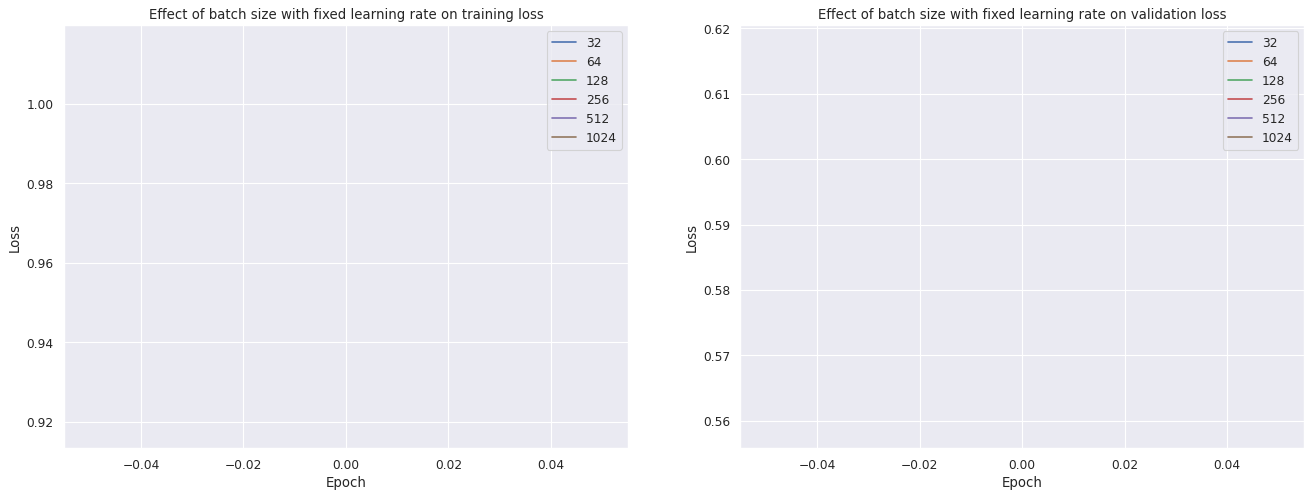

In [18]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate', 'fixed_lr_diff_bs_SGD_SAM')

#### Sharpness

In [19]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-25 17:50:21.730801: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.5944 - accuracy: 0.7878
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.94449D-01    |proj g|=  1.34326D-02
47/47 [==============================] - 0s 10ms/step - loss: 12.0825 - accuracy: 0.0999

At iterate    1    f= -1.20825D+01    |proj g|=  2.68652D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  35744     0 35743   2.687D-02  -1.208D+01
  F =  -12.082481384277344     

STOP: TOTAL NO. 

2022-02-25 17:50:29.092091: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.7052 - accuracy: 0.7616
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.05183D-01    |proj g|=  1.29210D-02
47/47 [==============================] - 1s 10ms/step - loss: 8.6311 - accuracy: 0.2875

At iterate    1    f= -8.63113D+00    |proj g|=  2.58421D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  33508     0 33507   2.584D-02  -8.631D+00
  F =  -8.6311340332031250     

STOP: TOTAL NO. o

2022-02-25 17:50:34.201473: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.8205 - accuracy: 0.7106
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.20474D-01    |proj g|=  1.25663D-02
47/47 [==============================] - 1s 11ms/step - loss: 7.9506 - accuracy: 0.2216

At iterate    1    f= -7.95063D+00    |proj g|=  2.51325D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  33025     0 33024   2.513D-02  -7.951D+00
  F =  -7.9506287574768066     

STOP: TOTAL NO. o

2022-02-25 17:50:40.433396: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 1.1213 - accuracy: 0.6439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12127D+00    |proj g|=  1.23857D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.7914 - accuracy: 0.1000

At iterate    1    f= -2.79136D+00    |proj g|=  2.47713D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  37362     0 37361   2.477D-02  -2.791D+00
  F =  -2.7913568019866943     

STOP: TOTAL NO. o

2022-02-25 17:50:46.623734: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 2.2016 - accuracy: 0.3702
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.20162D+00    |proj g|=  1.14679D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.3699 - accuracy: 0.0081

At iterate    1    f= -2.36992D+00    |proj g|=  2.29358D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  34165     0 34164   2.294D-02  -2.370D+00
  F =  -2.3699219226837158     

STOP: TOTAL NO. o

2022-02-25 17:50:52.168353: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 2.1983 - accuracy: 0.2442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19827D+00    |proj g|=  1.13931D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.4338 - accuracy: 0.0012

At iterate    1    f= -2.43380D+00    |proj g|=  2.27863D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  34045     0 34044   2.279D-02  -2.434D+00
  F =  -2.4338011741638184     

STOP: TOTAL NO. o

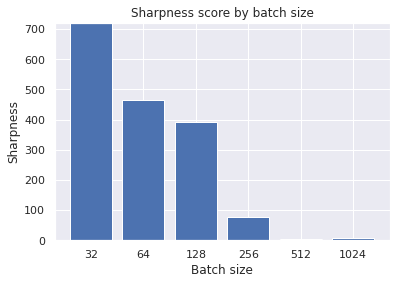

In [20]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


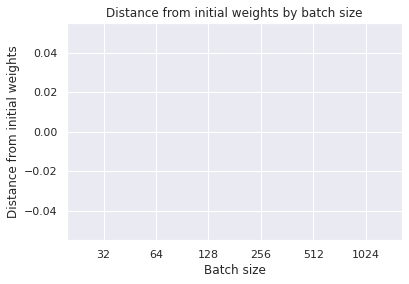

In [21]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [22]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.733158588409424
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  64
	Mean time per epoch:  5.292987585067749
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  128
	Mean time per epoch:  4.792391061782837
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  256
	Mean time per epoch:  4.41906213760376
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  512
	Mean time per epoch:  3.397695779800415
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  1024
	Mean time per epoch:  4.707241058349609
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


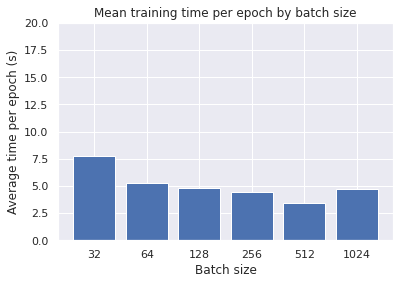

In [23]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

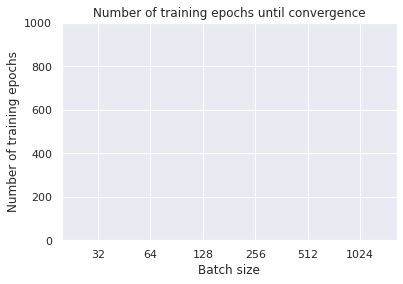

In [24]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

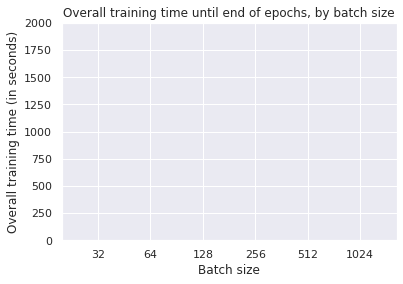

In [25]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

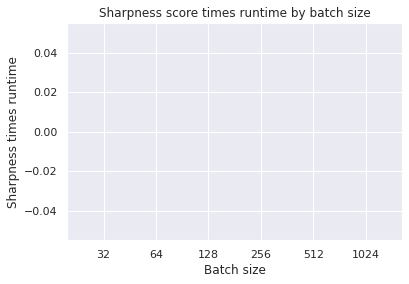

In [26]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### SGD with Momentum + ASAM

In [27]:
models_dict_fixed_sgd_asam = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'asam')

In [28]:
models_by_batch_size_fixed_lr_sgd_asam = {}

In [29]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))
        models_by_batch_size_fixed_lr_sgd_asam[batch_size] = model
        models[key + (batch_size,)] = model

In [30]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:51:00.690287: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1498/1500 [============================>.] - ETA: 0s - loss: 0.9974 - accuracy: 0.6186

2022-02-25 17:51:07.967509: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.56748, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_ASAM.tf
1500/1500 [==============================] - 9s 5ms/step - loss: 0.9970 - accuracy: 0.6186 - val_loss: 0.5675 - val_accuracy: 0.7976
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:51:10.174900: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


739/750 [============================>.] - ETA: 0s - loss: 1.2908 - accuracy: 0.5260

2022-02-25 17:51:15.405135: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69728, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_ASAM.tf
750/750 [==============================] - 7s 7ms/step - loss: 1.2834 - accuracy: 0.5283 - val_loss: 0.6973 - val_accuracy: 0.7593
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:51:17.306486: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


368/375 [============================>.] - ETA: 0s - loss: 1.5686 - accuracy: 0.4451

2022-02-25 17:51:20.581691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.83515, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_ASAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 1.5560 - accuracy: 0.4491 - val_loss: 0.8351 - val_accuracy: 0.6991
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:51:21.443600: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


184/188 [============================>.] - ETA: 0s - loss: 2.2037 - accuracy: 0.2611

2022-02-25 17:51:24.156682: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.84162, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_ASAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 2.1988 - accuracy: 0.2637 - val_loss: 1.8416 - val_accuracy: 0.4750
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:51:24.978104: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


94/94 [==============================] - ETA: 0s - loss: 2.2698 - accuracy: 0.1590

2022-02-25 17:51:27.482900: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.20046, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_ASAM.tf
94/94 [==============================] - 3s 27ms/step - loss: 2.2698 - accuracy: 0.1590 - val_loss: 2.2005 - val_accuracy: 0.2849
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:51:28.301479: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 2.2697 - accuracy: 0.1211

2022-02-25 17:51:30.746550: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.19228, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_ASAM.tf
47/47 [==============================] - 3s 52ms/step - loss: 2.2697 - accuracy: 0.1211 - val_loss: 2.1923 - val_accuracy: 0.2609


In [31]:
fixed_lr_sgd_asam_state_filename = 'model_fixed_lr_diff_bs_sgd_asam_state'

In [32]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], fixed_lr_sgd_asam_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(fixed_lr_sgd_asam_state_filename)

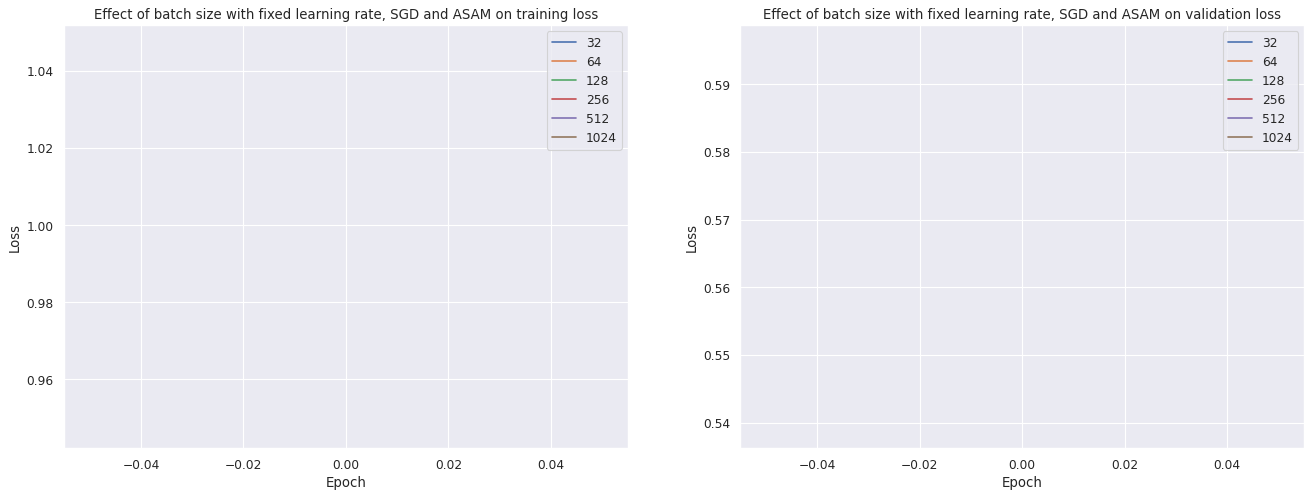

In [33]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, SGD and ASAM',
                                 'model_fixed_lr_diff_bs_sgd_asam_state')

#### Sharpness

In [34]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-25 17:51:31.819625: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.5740 - accuracy: 0.7941
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.73987D-01    |proj g|=  1.30066D-02
47/47 [==============================] - 1s 12ms/step - loss: 6.5548 - accuracy: 0.3617

At iterate    1    f= -6.55479D+00    |proj g|=  2.60131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  37975     0 37974   2.601D-02  -6.555D+00
  F =  -6.5547928810119629     

STOP: TOTAL NO. o

2022-02-25 17:51:36.952826: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.7028 - accuracy: 0.7568
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.02817D-01    |proj g|=  1.27699D-02
47/47 [==============================] - 1s 12ms/step - loss: 6.7271 - accuracy: 0.3396

At iterate    1    f= -6.72708D+00    |proj g|=  2.55398D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  35410     0 35409   2.554D-02  -6.727D+00
  F =  -6.7270760536193848     

STOP: TOTAL NO. o

2022-02-25 17:51:43.176984: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.8401 - accuracy: 0.6972
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.40089D-01    |proj g|=  1.25602D-02
47/47 [==============================] - 1s 13ms/step - loss: 10.3981 - accuracy: 0.1715

At iterate    1    f= -1.03981D+01    |proj g|=  2.51203D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  34626     0 34625   2.512D-02  -1.040D+01
  F =  -10.398088455200195     

STOP: TOTAL NO. 

2022-02-25 17:51:49.576085: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 1.8376 - accuracy: 0.4787
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.83761D+00    |proj g|=  1.18205D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.4671 - accuracy: 0.1011

At iterate    1    f= -2.46710D+00    |proj g|=  2.36410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  43729     0 43728   2.364D-02  -2.467D+00
  F =  -2.4671020507812500     

STOP: TOTAL NO. o

2022-02-25 17:51:55.797261: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 2.1991 - accuracy: 0.2952
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19910D+00    |proj g|=  1.14430D-02
47/47 [==============================] - 0s 10ms/step - loss: 2.3817 - accuracy: 0.0113

At iterate    1    f= -2.38166D+00    |proj g|=  2.28861D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  34303     0 34302   2.289D-02  -2.382D+00
  F =  -2.3816568851470947     

STOP: TOTAL NO. o

2022-02-25 17:52:01.046348: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 2.1910 - accuracy: 0.2608
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19101D+00    |proj g|=  1.14639D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.4371 - accuracy: 0.0068

At iterate    1    f= -2.43713D+00    |proj g|=  2.29277D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  35131     0 35130   2.293D-02  -2.437D+00
  F =  -2.4371294975280762     

STOP: TOTAL NO. o

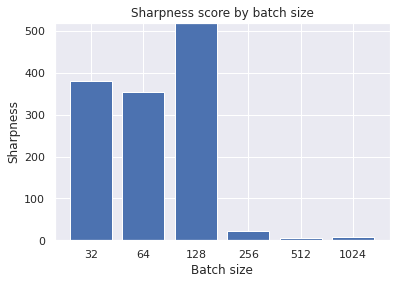

In [35]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


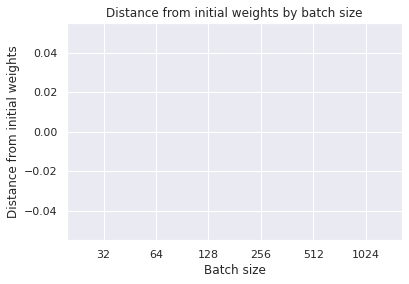

In [36]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [37]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  9.217643022537231
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  64
	Mean time per epoch:  6.857757091522217
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  128
	Mean time per epoch:  3.8627395629882812
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  256
	Mean time per epoch:  3.2650060653686523
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  512
	Mean time per epoch:  3.050767421722412
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  1024
	Mean time per epoch:  2.9644267559051514
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


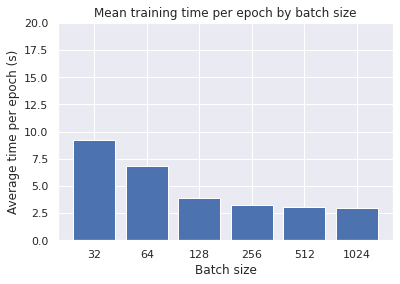

In [38]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

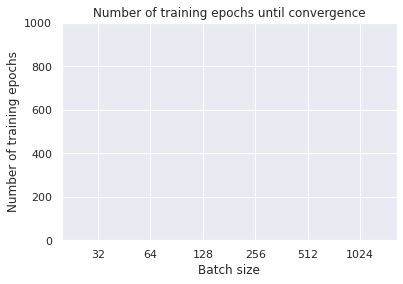

In [39]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

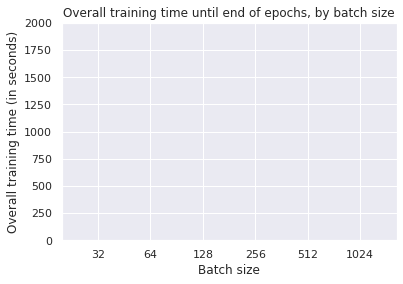

In [40]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

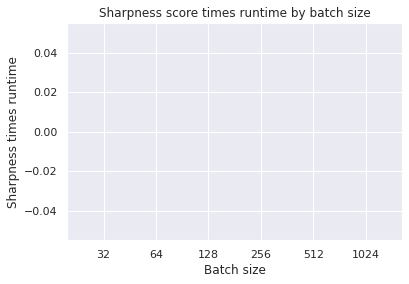

In [41]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM + SAM

In [42]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'sam')

In [43]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "SAM"))
        models[key + (batch_size,)] = model

In [44]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:52:08.542761: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1495/1500 [============================>.] - ETA: 0s - loss: 0.4894 - accuracy: 0.8125

2022-02-25 17:52:14.864525: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.32458, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_SAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4890 - accuracy: 0.8125 - val_loss: 0.3246 - val_accuracy: 0.8828
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:52:16.060449: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


750/750 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7939

2022-02-25 17:52:20.261412: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.36110, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_SAM.tf
750/750 [==============================] - 6s 7ms/step - loss: 0.5333 - accuracy: 0.7939 - val_loss: 0.3611 - val_accuracy: 0.8691
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:52:22.306635: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


371/375 [============================>.] - ETA: 0s - loss: 0.6291 - accuracy: 0.7580

2022-02-25 17:52:26.445469: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.41821, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_SAM.tf
375/375 [==============================] - 5s 8ms/step - loss: 0.6268 - accuracy: 0.7589 - val_loss: 0.4182 - val_accuracy: 0.8497
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:52:27.273724: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


186/188 [============================>.] - ETA: 0s - loss: 0.7445 - accuracy: 0.7146

2022-02-25 17:52:30.030410: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.46793, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_SAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.7422 - accuracy: 0.7154 - val_loss: 0.4679 - val_accuracy: 0.8326
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:52:30.857478: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


94/94 [==============================] - ETA: 0s - loss: 0.9014 - accuracy: 0.6589

2022-02-25 17:52:33.329165: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.54410, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_SAM.tf
94/94 [==============================] - 3s 26ms/step - loss: 0.9014 - accuracy: 0.6589 - val_loss: 0.5441 - val_accuracy: 0.8019
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:52:34.285090: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.5986

2022-02-25 17:52:36.750406: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69602, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_SAM.tf
47/47 [==============================] - 3s 52ms/step - loss: 1.1281 - accuracy: 0.5986 - val_loss: 0.6960 - val_accuracy: 0.7617


In [45]:
state_filename = 'model_fixed_lr_diff_bs_adam_sam_state'

In [46]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

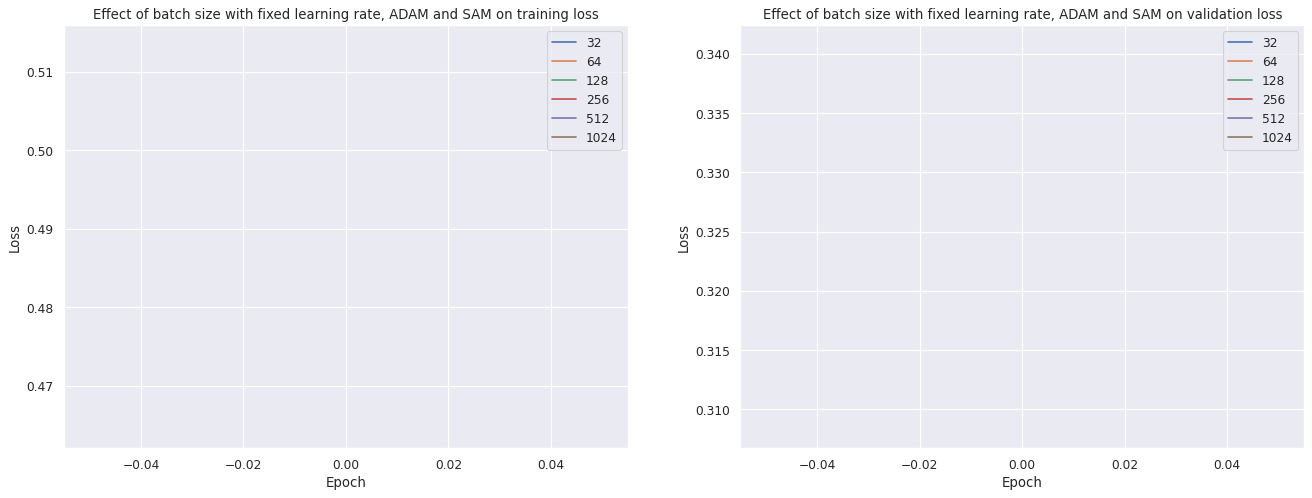

In [47]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and SAM',
                                 state_filename)

#### Sharpness

In [48]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-25 17:52:37.889348: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.3195 - accuracy: 0.8864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.19506D-01    |proj g|=  1.57444D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.2891 - accuracy: 0.5797

At iterate    1    f= -2.28906D+00    |proj g|=  2.98484D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  24080     0 24079   2.985D-02  -2.289D+00
  F =  -2.2890589237213135     

STOP: TOTAL NO. o

2022-02-25 17:52:43.057423: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.3613 - accuracy: 0.8702
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.61276D-01    |proj g|=  1.41869D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.0998 - accuracy: 0.4417

At iterate    1    f= -5.09975D+00    |proj g|=  2.83738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  31380     0 31379   2.837D-02  -5.100D+00
  F =  -5.0997548103332520     

STOP: TOTAL NO. o

2022-02-25 17:52:49.307652: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.4218 - accuracy: 0.8501
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.21781D-01    |proj g|=  1.26390D-02
47/47 [==============================] - 1s 12ms/step - loss: 7.6501 - accuracy: 0.3167

At iterate    1    f= -7.65007D+00    |proj g|=  2.52780D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  39707     0 39706   2.528D-02  -7.650D+00
  F =  -7.6500668525695801     

STOP: TOTAL NO. o

2022-02-25 17:52:55.789129: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.4721 - accuracy: 0.8299
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.72111D-01    |proj g|=  1.24750D-02
47/47 [==============================] - 1s 11ms/step - loss: 3.9117 - accuracy: 0.3546

At iterate    1    f= -3.91167D+00    |proj g|=  2.49499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  39111     0 39110   2.495D-02  -3.912D+00
  F =  -3.9116737842559814     

STOP: TOTAL NO. o

2022-02-25 17:53:01.977635: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.5506 - accuracy: 0.7979
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.50573D-01    |proj g|=  1.16985D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.9692 - accuracy: 0.4210

At iterate    1    f= -2.96919D+00    |proj g|=  2.33971D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  38003     0 38002   2.340D-02  -2.969D+00
  F =  -2.9691867828369141     

STOP: TOTAL NO. o

2022-02-25 17:53:09.379497: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.7003 - accuracy: 0.7571
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.00281D-01    |proj g|=  1.15968D-02
47/47 [==============================] - 1s 13ms/step - loss: 3.0487 - accuracy: 0.3222

At iterate    1    f= -3.04870D+00    |proj g|=  2.31937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  44540     0 44539   2.319D-02  -3.049D+00
  F =  -3.0487027168273926     

STOP: TOTAL NO. o

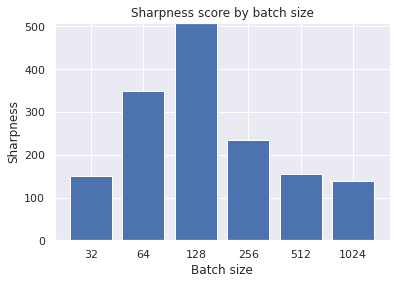

In [49]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


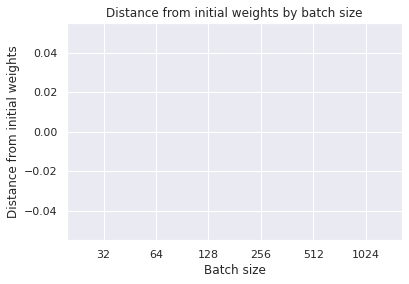

In [50]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [51]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.242304801940918
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  64
	Mean time per epoch:  5.957008600234985
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  128
	Mean time per epoch:  4.683143138885498
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  256
	Mean time per epoch:  3.2932379245758057
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  512
	Mean time per epoch:  2.987353563308716
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  1024
	Mean time per epoch:  2.996041774749756
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


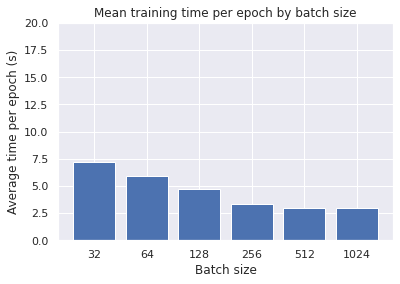

In [52]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

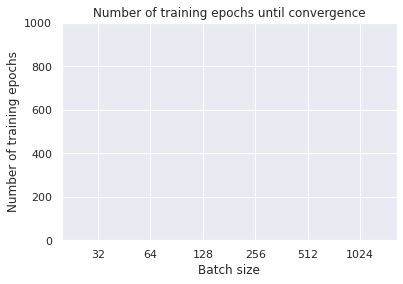

In [53]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

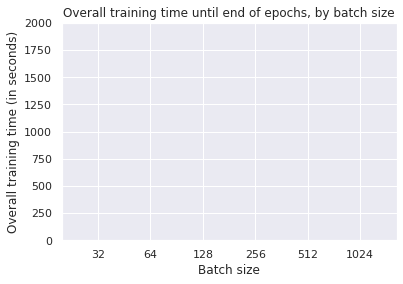

In [54]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

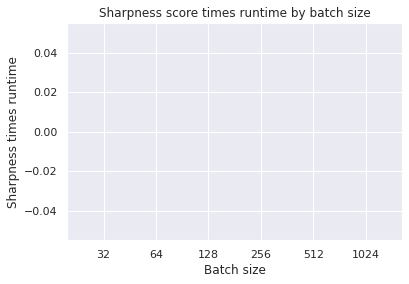

In [55]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM + ASAM

In [56]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'asam')

In [57]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))
        models[key + (batch_size,)] = model

In [58]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:53:15.752122: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1490/1500 [============================>.] - ETA: 0s - loss: 0.5254 - accuracy: 0.7932

2022-02-25 17:53:21.993788: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.33206, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_ASAM.tf
1500/1500 [==============================] - 7s 4ms/step - loss: 0.5242 - accuracy: 0.7936 - val_loss: 0.3321 - val_accuracy: 0.8799
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:53:23.134340: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


742/750 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.7784

2022-02-25 17:53:28.644113: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.37315, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_ASAM.tf
750/750 [==============================] - 6s 6ms/step - loss: 0.5646 - accuracy: 0.7791 - val_loss: 0.3732 - val_accuracy: 0.8625
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:53:29.564668: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


370/375 [============================>.] - ETA: 0s - loss: 0.6767 - accuracy: 0.7381

2022-02-25 17:53:32.813998: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.42539, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_ASAM.tf
375/375 [==============================] - 4s 9ms/step - loss: 0.6738 - accuracy: 0.7390 - val_loss: 0.4254 - val_accuracy: 0.8478
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:53:33.730493: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


186/188 [============================>.] - ETA: 0s - loss: 0.8036 - accuracy: 0.6896

2022-02-25 17:53:36.496663: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.48907, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_ASAM.tf
188/188 [==============================] - 3s 15ms/step - loss: 0.8009 - accuracy: 0.6906 - val_loss: 0.4891 - val_accuracy: 0.8253
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:53:37.325723: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


94/94 [==============================] - ETA: 0s - loss: 1.0189 - accuracy: 0.6302

2022-02-25 17:53:40.943175: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.56831, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_ASAM.tf
94/94 [==============================] - 4s 27ms/step - loss: 1.0189 - accuracy: 0.6302 - val_loss: 0.5683 - val_accuracy: 0.7915
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:53:41.988675: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 1.1791 - accuracy: 0.5860

2022-02-25 17:53:45.495269: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.69267, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_ASAM.tf
47/47 [==============================] - 4s 52ms/step - loss: 1.1791 - accuracy: 0.5860 - val_loss: 0.6927 - val_accuracy: 0.7639


In [59]:
state_filename = 'model_fixed_lr_diff_bs_adam_asam_state'

In [60]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

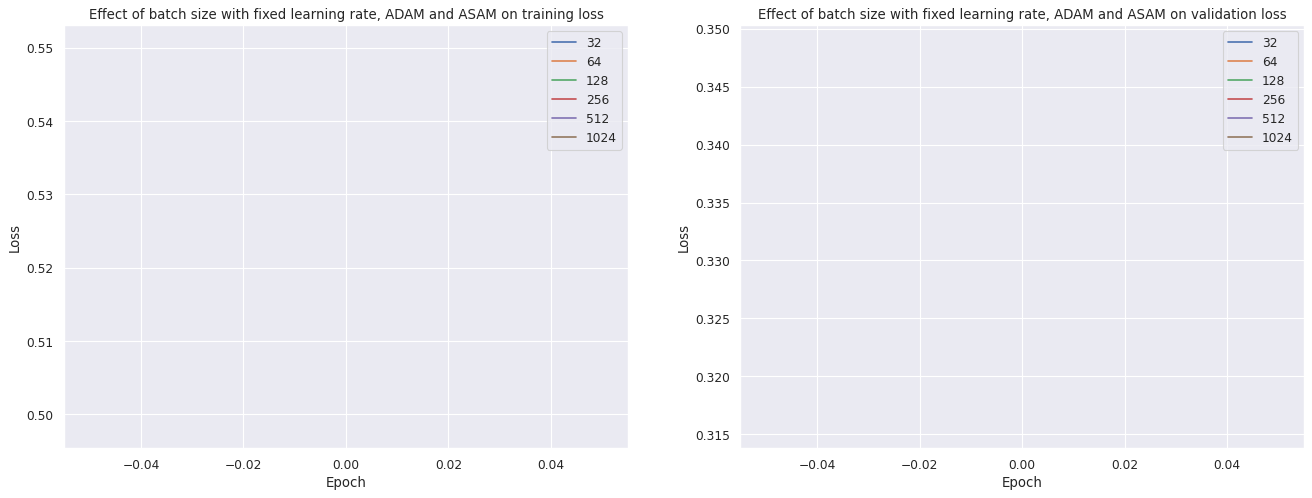

In [61]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate, ADAM and ASAM',
                                 state_filename)

#### Sharpness

In [62]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()


2022-02-25 17:53:46.615802: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.3303 - accuracy: 0.8818
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.30277D-01    |proj g|=  1.52252D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.9344 - accuracy: 0.5735

At iterate    1    f= -2.93441D+00    |proj g|=  3.04503D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  25544     0 25543   3.045D-02  -2.934D+00
  F =  -2.9344108104705811     

STOP: TOTAL NO. o

2022-02-25 17:53:51.798617: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 16ms/step - loss: 0.3736 - accuracy: 0.8657
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.73619D-01    |proj g|=  1.34604D-02
47/47 [==============================] - 1s 13ms/step - loss: 5.4126 - accuracy: 0.4255

At iterate    1    f= -5.41259D+00    |proj g|=  2.68606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  33419     0 33418   2.686D-02  -5.413D+00
  F =  -5.4125900268554688     

STOP: TOTAL NO. o

2022-02-25 17:53:59.186043: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.4315 - accuracy: 0.8458
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.31489D-01    |proj g|=  1.35167D-02
47/47 [==============================] - 1s 13ms/step - loss: 5.3882 - accuracy: 0.3437

At iterate    1    f= -5.38820D+00    |proj g|=  2.52566D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  37114     0 37113   2.526D-02  -5.388D+00
  F =  -5.3882036209106445     

STOP: TOTAL NO. o

2022-02-25 17:54:05.557285: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.4958 - accuracy: 0.8211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.95835D-01    |proj g|=  1.22637D-02
47/47 [==============================] - 1s 10ms/step - loss: 11.8585 - accuracy: 0.2357

At iterate    1    f= -1.18585D+01    |proj g|=  2.45273D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  41412     0 41411   2.453D-02  -1.186D+01
  F =  -11.858537673950195     

STOP: TOTAL NO. 

2022-02-25 17:54:12.742681: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 10ms/step - loss: 0.5753 - accuracy: 0.7864
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.75273D-01    |proj g|=  1.18191D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.2337 - accuracy: 0.5321

At iterate    1    f= -5.23366D+00    |proj g|=  2.34105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  41635     0 41634   2.341D-02  -5.234D+00
  F =  -5.2336592674255371     

STOP: TOTAL NO. o

2022-02-25 17:54:18.844237: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.6974 - accuracy: 0.7607
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.97361D-01    |proj g|=  1.16483D-02
47/47 [==============================] - 1s 12ms/step - loss: 4.8784 - accuracy: 0.3274

At iterate    1    f= -4.87841D+00    |proj g|=  2.32967D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  42612     0 42611   2.330D-02  -4.878D+00
  F =  -4.8784070014953613     

STOP: TOTAL NO. o

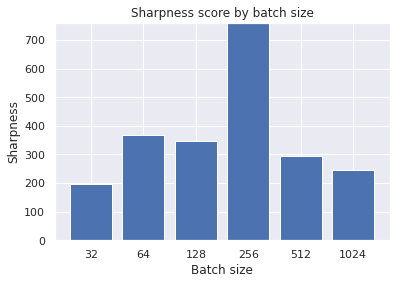

In [63]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


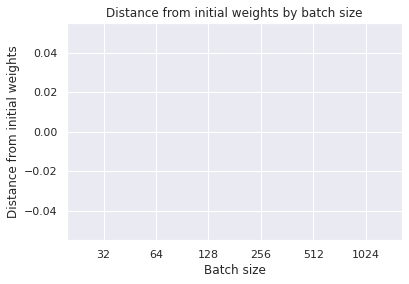

In [64]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [65]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.109747648239136
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  64
	Mean time per epoch:  6.143749475479126
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  128
	Mean time per epoch:  3.8724050521850586
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  256
	Mean time per epoch:  3.3058135509490967
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  512
	Mean time per epoch:  4.086438179016113
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  1024
	Mean time per epoch:  4.0148024559021
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


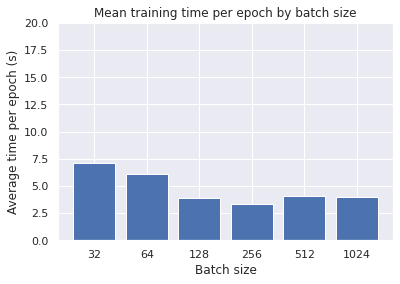

In [66]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

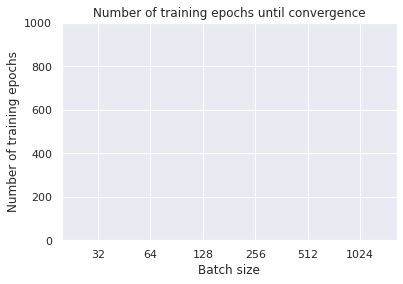

In [67]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

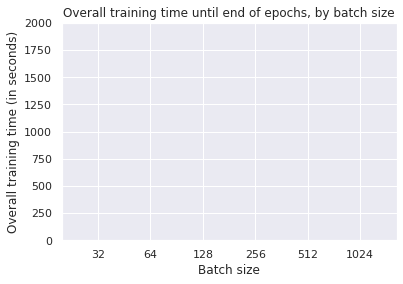

In [68]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

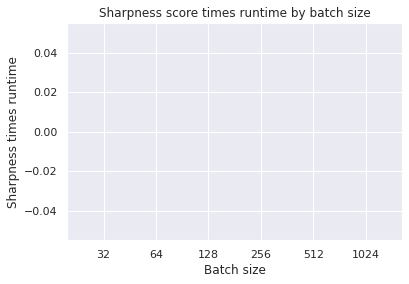

In [69]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

## without sharpness aware minimization

### SGD with Momentum

In [70]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'sgd', 'none')

In [71]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))
        models[key + (batch_size,)] = model

In [72]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "SGD-MOM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:54:25.470498: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1493/1500 [============================>.] - ETA: 0s - loss: 0.9658 - accuracy: 0.6459

2022-02-25 17:54:32.374279: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.67876, saving model to tmp/model_fixed_lr_diff_bs_32_opt_SGD-MOM_sam_NONE.tf
1500/1500 [==============================] - 8s 4ms/step - loss: 0.9644 - accuracy: 0.6464 - val_loss: 0.6788 - val_accuracy: 0.7763
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:54:33.647010: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


750/750 [==============================] - ETA: 0s - loss: 1.1196 - accuracy: 0.5914

2022-02-25 17:54:36.803678: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.78310, saving model to tmp/model_fixed_lr_diff_bs_64_opt_SGD-MOM_sam_NONE.tf
750/750 [==============================] - 5s 6ms/step - loss: 1.1196 - accuracy: 0.5914 - val_loss: 0.7831 - val_accuracy: 0.7343
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:54:38.761691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


369/375 [============================>.] - ETA: 0s - loss: 1.4391 - accuracy: 0.4770

2022-02-25 17:54:42.004337: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.87485, saving model to tmp/model_fixed_lr_diff_bs_128_opt_SGD-MOM_sam_NONE.tf
375/375 [==============================] - 5s 9ms/step - loss: 1.4310 - accuracy: 0.4795 - val_loss: 0.8749 - val_accuracy: 0.6793
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:54:43.830290: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


181/188 [===========================>..] - ETA: 0s - loss: 1.7313 - accuracy: 0.3818

2022-02-25 17:54:46.589210: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 1.05787, saving model to tmp/model_fixed_lr_diff_bs_256_opt_SGD-MOM_sam_NONE.tf
188/188 [==============================] - 3s 10ms/step - loss: 1.7094 - accuracy: 0.3885 - val_loss: 1.0579 - val_accuracy: 0.6416
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:54:47.376924: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


93/94 [============================>.] - ETA: 0s - loss: 2.1871 - accuracy: 0.2091

2022-02-25 17:54:49.249974: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.04127, saving model to tmp/model_fixed_lr_diff_bs_512_opt_SGD-MOM_sam_NONE.tf
94/94 [==============================] - 2s 22ms/step - loss: 2.1852 - accuracy: 0.2105 - val_loss: 2.0413 - val_accuracy: 0.4573
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:54:50.025066: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 2.2606 - accuracy: 0.1635

2022-02-25 17:54:51.548643: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.21462, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_SGD-MOM_sam_NONE.tf
47/47 [==============================] - 3s 57ms/step - loss: 2.2606 - accuracy: 0.1635 - val_loss: 2.2146 - val_accuracy: 0.2952


In [73]:
state_filename = 'model_fixed_lr_diff_bs_noSAM_state'

In [74]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

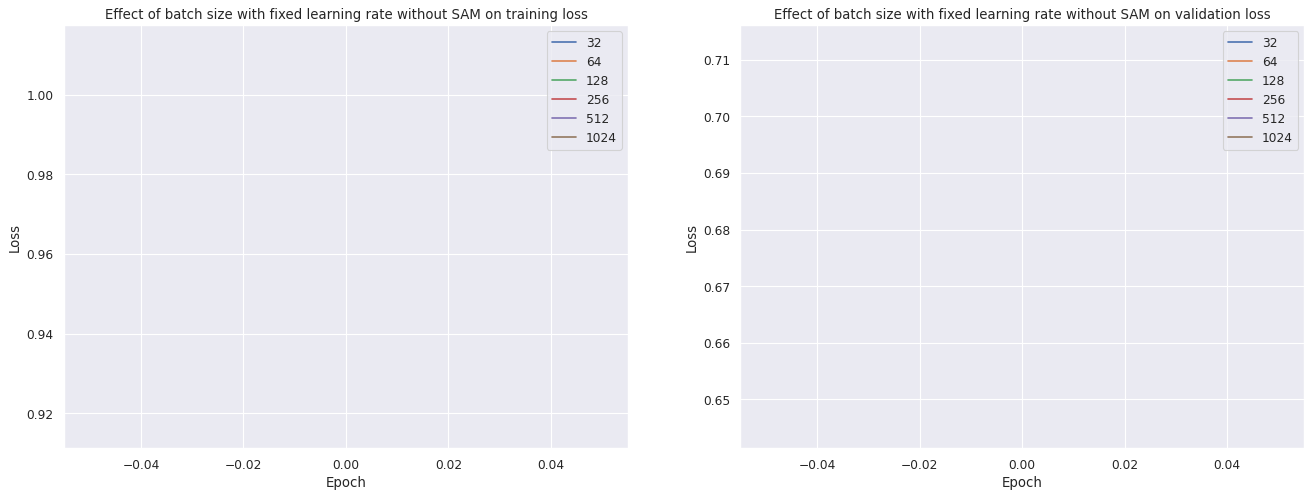

In [75]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM',
                                 'fixed_lr_diff_bs_SGD_noSAM')

#### Sharpness

In [76]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

 7/47 [===>..........................] - ETA: 0s - loss: 0.6741 - accuracy: 0.7799

2022-02-25 17:54:53.551622: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.6809 - accuracy: 0.7711
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.80920D-01    |proj g|=  1.27289D-02
47/47 [==============================] - 1s 10ms/step - loss: 3.7621 - accuracy: 0.2898

At iterate    1    f= -3.76209D+00    |proj g|=  2.54577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  38535     0 38534   2.546D-02  -3.762D+00
  F =  -3.7620851993560791     

STOP: TOTAL NO. o

2022-02-25 17:54:58.415977: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 11ms/step - loss: 0.7859 - accuracy: 0.7320
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.85855D-01    |proj g|=  1.24735D-02
47/47 [==============================] - 1s 11ms/step - loss: 6.2240 - accuracy: 0.2040

At iterate    1    f= -6.22403D+00    |proj g|=  2.49471D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  41783     0 41782   2.495D-02  -6.224D+00
  F =  -6.2240314483642578     

STOP: TOTAL NO. o

2022-02-25 17:55:03.409995: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.8778 - accuracy: 0.6759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.77776D-01    |proj g|=  1.25841D-02
47/47 [==============================] - 1s 12ms/step - loss: 4.1672 - accuracy: 0.1050

At iterate    1    f= -4.16722D+00    |proj g|=  2.51681D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  34694     0 34693   2.517D-02  -4.167D+00
  F =  -4.1672182083129883     

STOP: TOTAL NO. o

2022-02-25 17:55:08.433850: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 1.0581 - accuracy: 0.6405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.05812D+00    |proj g|=  1.22190D-02
47/47 [==============================] - 1s 12ms/step - loss: 2.6183 - accuracy: 0.1926

At iterate    1    f= -2.61832D+00    |proj g|=  2.44381D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  40069     0 40068   2.444D-02  -2.618D+00
  F =  -2.6183230876922607     

STOP: TOTAL NO. o

2022-02-25 17:55:13.446147: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 2.0393 - accuracy: 0.4629
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.03933D+00    |proj g|=  1.17147D-02
47/47 [==============================] - 1s 10ms/step - loss: 2.3509 - accuracy: 0.0035

At iterate    1    f= -2.35093D+00    |proj g|=  2.34293D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  37448     0 37447   2.343D-02  -2.351D+00
  F =  -2.3509283065795898     

STOP: TOTAL NO. o

2022-02-25 17:55:18.675615: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 16ms/step - loss: 2.2131 - accuracy: 0.3038
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.21314D+00    |proj g|=  1.14413D-02
47/47 [==============================] - 1s 10ms/step - loss: 2.4172 - accuracy: 0.0012

At iterate    1    f= -2.41723D+00    |proj g|=  2.28825D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  38550     0 38549   2.288D-02  -2.417D+00
  F =  -2.4172260761260986     

STOP: TOTAL NO. o

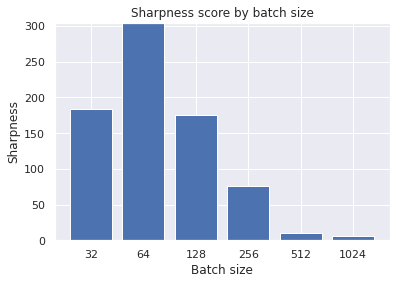

In [77]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


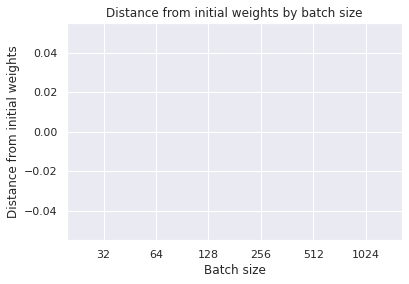

In [78]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [79]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  7.8967554569244385
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  64
	Mean time per epoch:  4.810036659240723
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  128
	Mean time per epoch:  4.793776035308838
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  256
	Mean time per epoch:  3.272247791290283
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  512
	Mean time per epoch:  2.3847172260284424
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  1024
	Mean time per epoch:  2.978257179260254
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


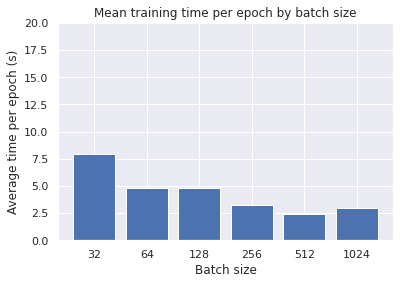

In [80]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

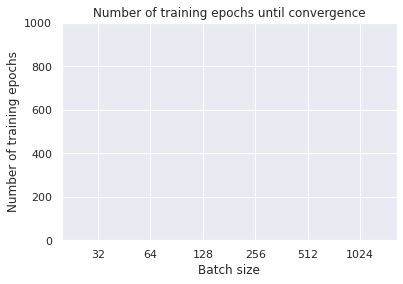

In [81]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

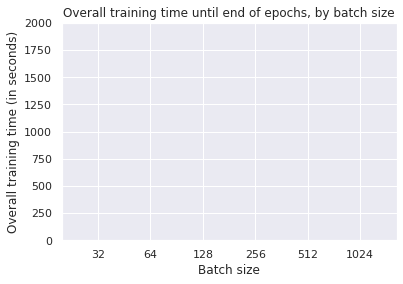

In [82]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

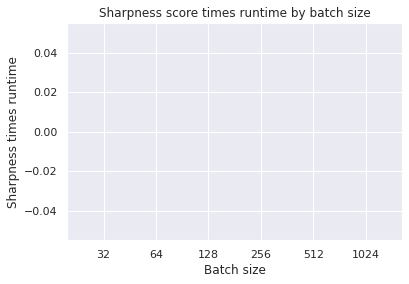

In [83]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

### ADAM

In [84]:
batch_sizes = [32, 64, 128, 256, 512, 1024]
lr = 0.001
training_epochs = EPOCHS

key = ('fixed', 'adam', 'none')

In [85]:
if not RETRAIN_FLAG:
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "ADAM", "NONE"))
        models[key + (batch_size,)] = model

In [86]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size in batch_sizes:
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_opt_sam(batch_size, "ADAM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size,)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:55:24.673276: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1495/1500 [============================>.] - ETA: 0s - loss: 0.5816 - accuracy: 0.7879

2022-02-25 17:55:28.992476: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.38439, saving model to tmp/model_fixed_lr_diff_bs_32_opt_ADAM_sam_NONE.tf
1500/1500 [==============================] - 5s 3ms/step - loss: 0.5812 - accuracy: 0.7880 - val_loss: 0.3844 - val_accuracy: 0.8642
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:55:30.038207: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


748/750 [============================>.] - ETA: 0s - loss: 0.6104 - accuracy: 0.7783

2022-02-25 17:55:32.758120: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.40259, saving model to tmp/model_fixed_lr_diff_bs_64_opt_ADAM_sam_NONE.tf
750/750 [==============================] - 4s 5ms/step - loss: 0.6098 - accuracy: 0.7785 - val_loss: 0.4026 - val_accuracy: 0.8595
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:55:34.613770: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


370/375 [============================>.] - ETA: 0s - loss: 0.6872 - accuracy: 0.7476

2022-02-25 17:55:37.687990: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.46243, saving model to tmp/model_fixed_lr_diff_bs_128_opt_ADAM_sam_NONE.tf
375/375 [==============================] - 5s 9ms/step - loss: 0.6848 - accuracy: 0.7483 - val_loss: 0.4624 - val_accuracy: 0.8314
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:55:39.474573: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


187/188 [============================>.] - ETA: 0s - loss: 0.8003 - accuracy: 0.7051

2022-02-25 17:55:42.222753: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.51048, saving model to tmp/model_fixed_lr_diff_bs_256_opt_ADAM_sam_NONE.tf
188/188 [==============================] - 3s 10ms/step - loss: 0.7994 - accuracy: 0.7054 - val_loss: 0.5105 - val_accuracy: 0.8181
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:55:43.065296: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


91/94 [============================>.] - ETA: 0s - loss: 0.9490 - accuracy: 0.6528

2022-02-25 17:55:45.708070: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.59774, saving model to tmp/model_fixed_lr_diff_bs_512_opt_ADAM_sam_NONE.tf
94/94 [==============================] - 3s 19ms/step - loss: 0.9399 - accuracy: 0.6558 - val_loss: 0.5977 - val_accuracy: 0.7954
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:55:46.462813: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 1.1348 - accuracy: 0.5854

2022-02-25 17:55:50.032030: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.71692, saving model to tmp/model_fixed_lr_diff_bs_1024_opt_ADAM_sam_NONE.tf
47/47 [==============================] - 4s 35ms/step - loss: 1.1348 - accuracy: 0.5854 - val_loss: 0.7169 - val_accuracy: 0.7620


In [87]:
state_filename = 'model_fixed_lr_diff_bs_ADAM_noSAM_state'

In [88]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

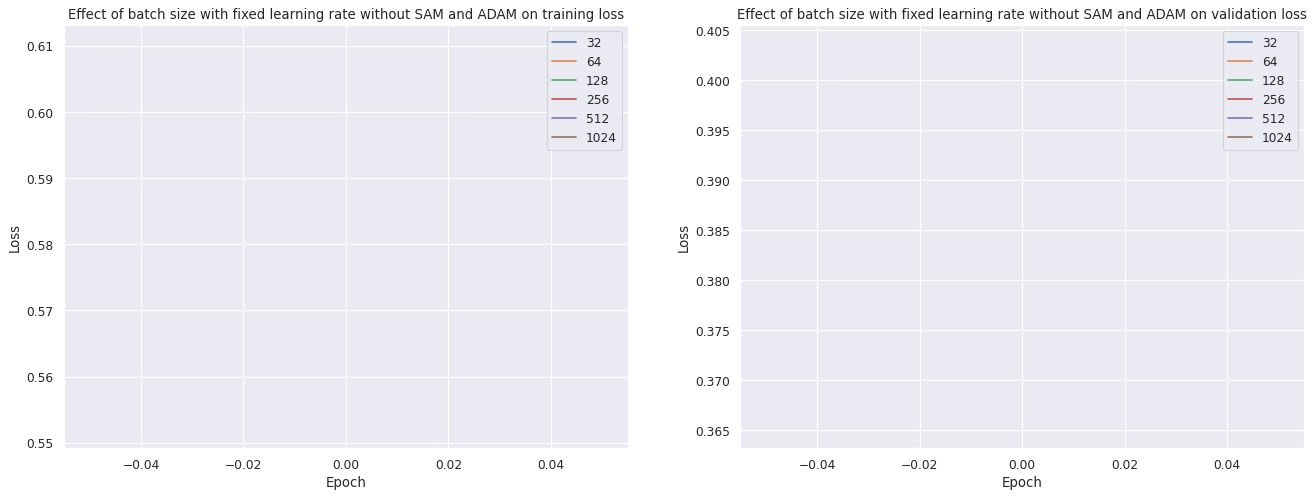

In [89]:
visualization.plot_loss_by_param(models_states[key], 'batch size with fixed learning rate without SAM and ADAM',
                                 'fixed_lr_diff_bs_ADAM_noSAM')

#### Sharpness

In [90]:
if RETRAIN_FLAG:
    for batch_size in batch_sizes:
        model = models[key + (batch_size,)]

        sharpness_bs = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size,)] = sharpness_bs

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

 7/47 [===>..........................] - ETA: 0s - loss: 0.3837 - accuracy: 0.8679

2022-02-25 17:55:51.098477: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 0.3862 - accuracy: 0.8652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.86221D-01    |proj g|=  1.38211D-02
47/47 [==============================] - 1s 12ms/step - loss: 1.1892 - accuracy: 0.6304

At iterate    1    f= -1.18922D+00    |proj g|=  2.66836D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  23695     0 23694   2.668D-02  -1.189D+00
  F =  -1.1892166137695312     

STOP: TOTAL NO. o

2022-02-25 17:55:56.420640: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.4049 - accuracy: 0.8596
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.04898D-01    |proj g|=  1.44580D-02
47/47 [==============================] - 1s 11ms/step - loss: 1.8411 - accuracy: 0.5216

At iterate    1    f= -1.84114D+00    |proj g|=  2.60177D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  32809     0 32808   2.602D-02  -1.841D+00
  F =  -1.8411402702331543     

STOP: TOTAL NO. o

2022-02-25 17:56:01.396061: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 0.4675 - accuracy: 0.8332
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.67482D-01    |proj g|=  1.25387D-02
47/47 [==============================] - 1s 11ms/step - loss: 12.6297 - accuracy: 0.3319

At iterate    1    f= -1.26297D+01    |proj g|=  2.48179D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  44961     0 44960   2.482D-02  -1.263D+01
  F =  -12.629728317260742     

STOP: TOTAL NO. 

2022-02-25 17:56:06.456288: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.5154 - accuracy: 0.8162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.15401D-01    |proj g|=  1.22306D-02
47/47 [==============================] - 1s 11ms/step - loss: 2.7176 - accuracy: 0.3886

At iterate    1    f= -2.71757D+00    |proj g|=  2.43230D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  37601     0 37600   2.432D-02  -2.718D+00
  F =  -2.7175707817077637     

STOP: TOTAL NO. o

2022-02-25 17:56:11.374044: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 12ms/step - loss: 0.5999 - accuracy: 0.7921
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.99935D-01    |proj g|=  1.19727D-02
47/47 [==============================] - 1s 11ms/step - loss: 5.5247 - accuracy: 0.2866

At iterate    1    f= -5.52472D+00    |proj g|=  2.39453D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  42612     0 42611   2.395D-02  -5.525D+00
  F =  -5.5247240066528320     

STOP: TOTAL NO. o

2022-02-25 17:56:16.523662: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.7186 - accuracy: 0.7594
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -7.18602D-01    |proj g|=  1.16438D-02
47/47 [==============================] - 1s 12ms/step - loss: 3.4250 - accuracy: 0.3302

At iterate    1    f= -3.42496D+00    |proj g|=  2.32875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  46500     0 46499   2.329D-02  -3.425D+00
  F =  -3.4249560832977295     

STOP: TOTAL NO. o

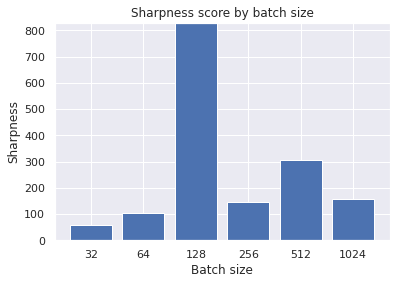

In [91]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key)

#### Distance from initial weights

Batch size: 32, distance: 0.0
Batch size: 64, distance: 0.0
Batch size: 128, distance: 0.0
Batch size: 256, distance: 0.0
Batch size: 512, distance: 0.0
Batch size: 1024, distance: 0.0


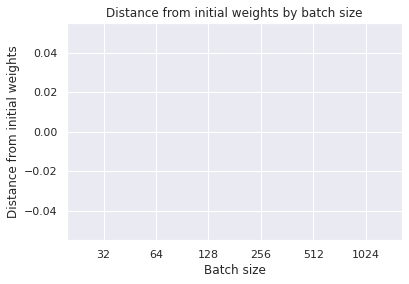

In [92]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [93]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

Batch size:  32
	Mean time per epoch:  5.106670379638672
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  64
	Mean time per epoch:  4.311381101608276
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  128
	Mean time per epoch:  4.600414752960205
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  256
	Mean time per epoch:  3.2536940574645996
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  512
	Mean time per epoch:  3.1388049125671387
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0
Batch size:  1024
	Mean time per epoch:  4.072374582290649
	Converged in 0 epochs
	Overall training time (in seconds) until convergence:  0.0


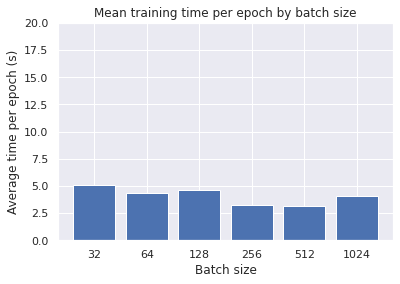

In [94]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

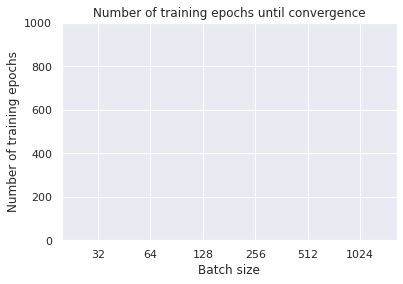

In [95]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

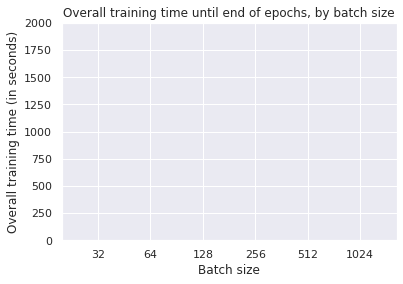

In [96]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

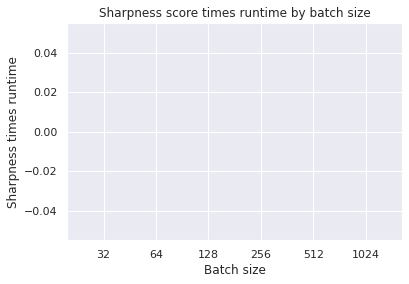

In [97]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key)

# Different batch sizes with linear increasing learning rate

## with sharpness aware minimization

### SGD with Momentum + SAM

In [98]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'sam')

In [99]:
models_by_batch_size_diff_lr = {}
model_history_dict_diff_lr = {}

In [100]:
diff_lr_state_filename = 'model_diff_lr_diff_bs_state'

In [101]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [102]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:56:22.540567: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


1488/1500 [============================>.] - ETA: 0s - loss: 0.9778 - accuracy: 0.6220

2022-02-25 17:56:30.488487: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.56280, saving model to tmp/model_lr_0.001_diff_bs_32_opt_SGD-MOM_sam_SAM.tf
1500/1500 [==============================] - 10s 5ms/step - loss: 0.9747 - accuracy: 0.6231 - val_loss: 0.5628 - val_accuracy: 0.7997
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:56:32.614457: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


747/750 [============================>.] - ETA: 0s - loss: 1.0094 - accuracy: 0.6165

2022-02-25 17:56:37.342489: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.58159, saving model to tmp/model_lr_0.002_diff_bs_64_opt_SGD-MOM_sam_SAM.tf
750/750 [==============================] - 6s 6ms/step - loss: 1.0079 - accuracy: 0.6170 - val_loss: 0.5816 - val_accuracy: 0.7935
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:56:39.183743: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


375/375 [==============================] - ETA: 0s - loss: 1.0435 - accuracy: 0.6077

2022-02-25 17:56:44.160612: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.59603, saving model to tmp/model_lr_0.004_diff_bs_128_opt_SGD-MOM_sam_SAM.tf
375/375 [==============================] - 6s 8ms/step - loss: 1.0435 - accuracy: 0.6077 - val_loss: 0.5960 - val_accuracy: 0.7922
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:56:44.961522: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


183/188 [============================>.] - ETA: 0s - loss: 1.1226 - accuracy: 0.5846

2022-02-25 17:56:48.557662: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.60945, saving model to tmp/model_lr_0.008_diff_bs_256_opt_SGD-MOM_sam_SAM.tf
188/188 [==============================] - 5s 19ms/step - loss: 1.1126 - accuracy: 0.5885 - val_loss: 0.6095 - val_accuracy: 0.7816
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:56:50.377394: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


93/94 [============================>.] - ETA: 0s - loss: 1.3194 - accuracy: 0.5363

2022-02-25 17:56:53.831082: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 0.64341, saving model to tmp/model_lr_0.016_diff_bs_512_opt_SGD-MOM_sam_SAM.tf
94/94 [==============================] - 5s 37ms/step - loss: 1.3140 - accuracy: 0.5380 - val_loss: 0.6434 - val_accuracy: 0.7728
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
2022-02-25 17:56:55.630492: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - ETA: 0s - loss: 2.1406 - accuracy: 0.3344

2022-02-25 17:56:58.968247: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.



Epoch 1: val_loss improved from inf to 2.06006, saving model to tmp/model_lr_0.032_diff_bs_1024_opt_SGD-MOM_sam_SAM.tf
47/47 [==============================] - 4s 48ms/step - loss: 2.1406 - accuracy: 0.3344 - val_loss: 2.0601 - val_accuracy: 0.5155


In [103]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], diff_lr_state_filename)
else:
    models_states[key] = ml_utils.load_model_state(diff_lr_state_filename)

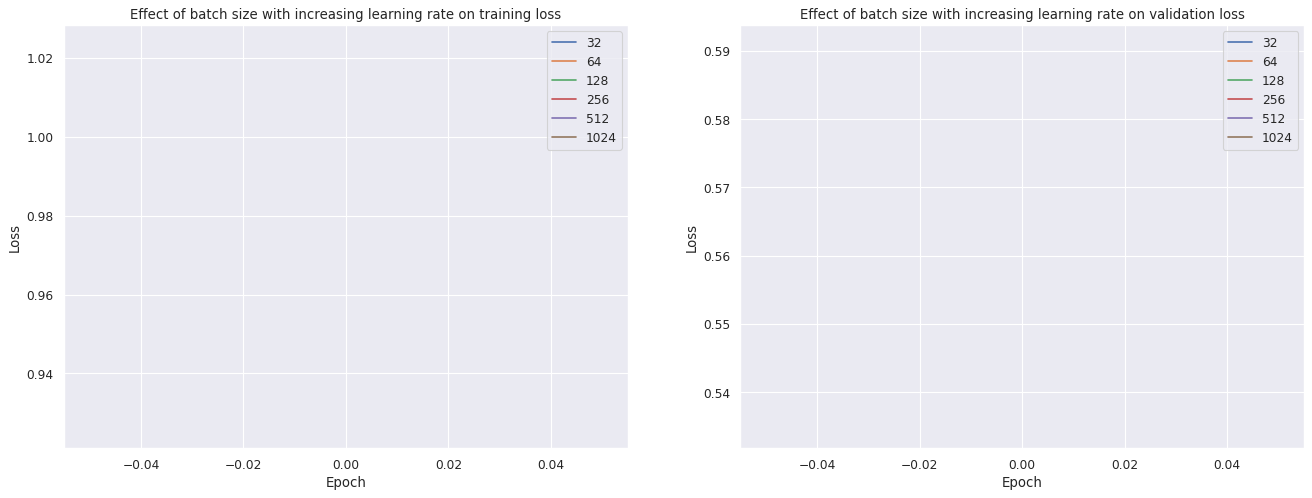

In [104]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate',
                                 'diff_lr_diff_bs')

#### Sharpness

In [105]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, )] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

2022-02-25 17:56:59.972895: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.5690 - accuracy: 0.7968
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.69048D-01    |proj g|=  1.26171D-02
47/47 [==============================] - 1s 13ms/step - loss: 6.5308 - accuracy: 0.2803

At iterate    1    f= -6.53082D+00    |proj g|=  2.52342D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  38788     0 38787   2.523D-02  -6.531D+00
  F =  -6.5308246612548828     

STOP: TOTAL NO. o

2022-02-25 17:57:06.481171: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.5878 - accuracy: 0.7884
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.87753D-01    |proj g|=  1.34401D-02
47/47 [==============================] - 1s 11ms/step - loss: 7.3327 - accuracy: 0.3824

At iterate    1    f= -7.33272D+00    |proj g|=  2.68801D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  35848     0 35847   2.688D-02  -7.333D+00
  F =  -7.3327174186706543     

STOP: TOTAL NO. o

2022-02-25 17:57:13.761759: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.6010 - accuracy: 0.7899
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.01007D-01    |proj g|=  1.26813D-02
47/47 [==============================] - 1s 12ms/step - loss: 9.0266 - accuracy: 0.2184

At iterate    1    f= -9.02664D+00    |proj g|=  2.53626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  36794     0 36793   2.536D-02  -9.027D+00
  F =  -9.0266427993774414     

STOP: TOTAL NO. o

2022-02-25 17:57:20.001413: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 14ms/step - loss: 0.6149 - accuracy: 0.7755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.14853D-01    |proj g|=  1.35356D-02
47/47 [==============================] - 1s 12ms/step - loss: 12.3435 - accuracy: 0.2674

At iterate    1    f= -1.23435D+01    |proj g|=  2.70713D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  39239     0 39238   2.707D-02  -1.234D+01
  F =  -12.343524932861328     

STOP: TOTAL NO. 

2022-02-25 17:57:26.239475: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 13ms/step - loss: 0.6467 - accuracy: 0.7742
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.46653D-01    |proj g|=  1.29690D-02
47/47 [==============================] - 1s 11ms/step - loss: 3.9452 - accuracy: 0.3944

At iterate    1    f= -3.94524D+00    |proj g|=  2.59380D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  32607     0 32606   2.594D-02  -3.945D+00
  F =  -3.9452414512634277     

STOP: TOTAL NO. o

2022-02-25 17:57:33.700028: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:547] The `assert_cardinality` transformation is currently not handled by the auto-shard rewrite and will be removed.


47/47 [==============================] - 1s 15ms/step - loss: 2.0820 - accuracy: 0.5128
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.08203D+00    |proj g|=  1.50998D-02
47/47 [==============================] - 1s 11ms/step - loss: 21.7570 - accuracy: 0.2034

At iterate    1    f= -2.17570D+01    |proj g|=  2.52582D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      1      2  25497     0 25496   2.526D-02  -2.176D+01
  F =  -21.756986618041992     

STOP: TOTAL NO. 

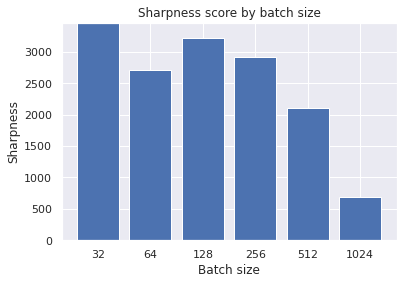

In [106]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [107]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key, learning_rates)

KeyError: ('increasing', 'sgd', 'sam', 32)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### SGD with Momentum + ASAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'sgd', 'asam')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_sgd_asam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_simple_cnn_sam(train, optimizer, adaptive=True, rho=2.0)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD-MOM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD and ASAM',
                                 'diff_lr_diff_bs_SGD_ASAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM + SAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'sam')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_adam_sam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "SAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and SAM',
                                 'diff_lr_diff_bs_ADAM_SAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## ADAM + ASAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'asam')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_adam_asam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_sam_model_weights(train, optimizer,
                                                 filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))
        models_by_batch_size_diff_lr[batch_size] = model
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_simple_cnn_sam(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "ASAM"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

In [ ]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_states[key], state_filename)
else:
    models_states[key] = ml_utils.load_model_state(state_filename)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM and ASAM',
                                 'diff_lr_diff_bs_ADAM_ASAM')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model.base_model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

## without sharpness aware minimization

### SGD with Momentum

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'SGD', 'none')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_sgd_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "SGD", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with SGD',
                                 'diff_lr_diff_bs_SGD_NONE')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
# Save to Drive in case we run on Google Colab
if USE_COLAB:
    !cp -r /content/graphs/ /content/drive/MyDrive/
    !cp -r /content/tmp/ /content/drive/MyDrive/

### ADAM

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]
batch_sizes = [32, 64, 128, 256, 512, 1024]
training_epochs = EPOCHS

key = ('increasing', 'adam', 'none')

In [ ]:
state_filename = 'model_diff_lr_diff_bs_adam_state'

In [ ]:
if not RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                          batch_size=batch_size,
                                                                          img_size=32)
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        model = build_and_load_model_weights(train, optimizer,
                                             filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))
        models[key + (batch_size, lr)] = model

In [ ]:
if RETRAIN_FLAG:
    models_states[key] = {}
    for batch_size, lr in zip(batch_sizes, learning_rates):
        with tf.distribute.MirroredStrategy().scope():
            # Read training data
            train, validation = data_loading.load_batched_and_resized_dataset(dataset_name=dataset_name,
                                                                              batch_size=batch_size,
                                                                              img_size=32)

            optimizer = keras.optimizers.Adam(learning_rate=lr)
            model = tf_models.build_and_compile_simple_cnn(train, optimizer)
            train_callbacks = callback_for_filename(filename_bs_lr_opt_sam(batch_size, lr, "ADAM", "NONE"))

            models_states[key][batch_size] = ml_utils.train_model(model, train, validation, epochs=training_epochs,
                                                                  extra_callbacks=train_callbacks, verbose=1)
            models[key + (batch_size, lr)] = model
            initial_weights[key + (batch_size,)] = model.get_weights()
            ml_utils.save_initial_weights_dict(initial_weights)

In [ ]:
visualization.plot_loss_by_param(models_states[key], 'batch size with increasing learning rate with ADAM',
                                 'diff_lr_diff_bs_ADAM_NONE')

#### Sharpness

In [ ]:
if RETRAIN_FLAG:
    for batch_size, lr in zip(batch_sizes, learning_rates):
        model = models[key + (batch_size, lr)]

        sharpness = visualization.get_sharpness(model, train)
        sharpnesses[key + (batch_size, lr)] = sharpness

        ml_utils.save_sharpnesses_dict(sharpnesses)

if not RETRAIN_FLAG:
    sharpnesses = ml_utils.load_sharpnesses_dict()

In [ ]:
visualization.plot_sharpness(batch_sizes, sharpnesses, key, learning_rates)

#### Distance from initial weights

In [ ]:
visualization.plot_distance_from_initial_weight(models, initial_weights, batch_sizes, key)

#### Runtime

In [ ]:
mean_times, convergence_epochs, overall_training_times = visualization.extract_times_for_batch_sizes(models_states,
                                                                                                     batch_sizes, key)

In [ ]:
visualization.plot_mean_time_per_epoch(batch_sizes, mean_times)

In [ ]:
visualization.histogram_num_of_train_epochs_until_conv(batch_sizes, convergence_epochs)

In [ ]:
visualization.histogram_overall_time_until_end_of_epochs(batch_sizes, overall_training_times)

In [ ]:
visualization.plot_sharpness_times_runtime(batch_sizes, overall_training_times, sharpnesses, key, learning_rates)

In [ ]:
sharpnesses.keys()

In [ ]:
initial_weights.keys()